# Projekt SE
swfqedg


In [1]:
###############################################################################
# blabla
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
import pandas as pd
import numpy as np

from scipy.io import loadmat
from scipy.stats import kurtosis
from scipy.stats import skew

import time
from sys import getsizeof

from itertools import permutations, count #,izip

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg


from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.losses import BinaryCrossentropy, mean_squared_error, KLDivergence# SparseCategoricalCrossentropy
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping


%load_ext autoreload
%autoreload 2

Hilfsfunktionen definieren

In [2]:
def plot_stats(dr, axis=0, color='tab:blue', plot=False):
        
    a = (np.std(dr, axis=axis))
    b = (np.var(dr, axis=axis))
    c = (skew(dr, axis=axis))
    d = (kurtosis(dr, axis=axis))
    
    if plot:
        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(111)

        ax.set_title('Histogramm')
        sns.distplot(dr,  ax=ax, color=color);
        #ax.legend((*hist.legend_elements()))
        plt.show()
    
    
        fig = plt.figure(figsize=(14,14))
        ax1 = fig.add_subplot(221)
        ax1.plot(a, 'tab:red', label='std')
        ax1.legend()
        ax2 = fig.add_subplot(222)
        ax2.plot(b, 'tab:green', label='var')
        ax2.legend()
        ax3 = fig.add_subplot(223)
        ax3.plot(d, 'tab:purple', label='kurtosis')
        ax3.legend()
        ax4 = fig.add_subplot(224)
        ax4.plot(c, 'tab:olive', label='skew')
        ax4.legend()
        plt.show()
    
    return a, b, c, d

In [3]:
def clust_eval(y_pred, y_train, name=""):
    fig1 = plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(1,2)

    ax1 = plt.subplot(gs[0])
    cnf_matrix = confusion_matrix(y_train,y_pred)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    #print(cnf_matrix)
    #print(row_sum)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True, xticklabels=["1 good","0 defect"], yticklabels=["1 good","0 defect"])

    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    plt.title(f"Normalized Confusion Matrix - {name}")


    #ROC Curve Trainingdata 



    ax3 = plt.subplot(gs[1])

    fpr, tpr, thresholds = roc_curve(y_train, y_pred)

    roc_auc = auc(fpr, tpr)

    
    plt.plot(fpr, tpr, lw=1, alpha=0.9,
             label='ROC (AUC = %0.2f)' % (roc_auc))


    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.7)


    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    
    return roc_auc

In [4]:
def ae_classy(mse, threshold):
    y_pred_ae = []

    for i, loss in enumerate(mse):

        if loss >= threshold:
            y_pred_ae.append(0) # defect
        else:
            y_pred_ae.append(1) # good
            
    return y_pred_ae

In [218]:
def create_model(loss_fn = "mse", input_dim=2, file="autoencoder.h5"):    
    
    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(int(input_dim / 2), activation="relu")(input_layer)

    dropout = Dropout(0.2)(encoder)

    encoder = Dense(int(input_dim / 4), activation="relu")(dropout)

    dropout = Dropout(0.2)(encoder)

    decoder = Dense(int(input_dim / 2), activation='relu')(dropout)

    decoder = Dense(input_dim, activation=None)(decoder)

    checkpointer = ModelCheckpoint(filepath=file,
                           verbose=0,
                           save_best_only=True)

    early_stopping = EarlyStopping(patience=patience,
                           verbose=0,
                           restore_best_weights=True)

    
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    autoencoder.compile(optimizer='adam', 
                    loss=loss_fn,
                       metrics=['accuracy'])
    #autoencoder.compile(optimizer='adadelta',
#                    loss='binary_crossentropy', 
#                    metrics=['accuracy'])

    
    return autoencoder, checkpointer, early_stopping

# MATLAB Matizen laden
Die Datensets befinden sich im MATLAB Format und werden zunachst geladen.

In [6]:

path = "D:/Documents/Uni/Special Engineering/Projektdaten/"

files = ["fftArray_defectLines.mat",
         "fftArray_goodLines.mat",
         "realSpace_defectLines.mat",
         "realSpace_goodLines.mat",
         "timeTable_defectLines.mat",
         "timeTable_goodLines.mat"]

keys =['fftFeat','fftFeat','realSpace','realSpace','timeTable','timeTable']


mat = []
data =[]

for f in files:
    mat.append(loadmat(path+f))

    
for i, m in enumerate(mat[:-2]):
    
    ds = m[keys[i]]
    
    print(getsizeof(ds),np.shape(ds),np.max(ds))
    
    data.append(pd.DataFrame(ds))
    
    #data.append(m[keys[i]])
#data = mat['fftFeat']

112 (111, 17089) 26.413447263145173
112 (109, 17236) 16.648241834407273
112 (223, 17089) 590.1683374744971
112 (218, 17236) 592.5773385229529


in erster Linie sind die ersten beiden Datensets interessant.


# Quellen

Measures of Skewness and Kurtosis
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm


In [14]:

series = []
title = ['defect','good']

#series.append(data[2].T[0:17089].T)
#series.append(data[3].T[0:17089].T)
series.append(data[2][0:218].T[0:17089].T)
series.append(data[3].T[0:17089].T)

for s in series:
    print(np.shape(s))


(218, 17089)
(218, 17089)


# PCA on Realspace data
Aufgrund der extrem hohen Dimensionalistät bietet es sich an die Anzahl der Features mittel Pr zu reduzieren.

In [74]:
series_pca = []
pcas = []
pca = None



for t in series:
#
   # for i,_ in enumerate(t):
    t = t.T
    

    
    #l = np.size(t,1)/10

    pca = PCA(n_components=80)
    
    pc = pca.fit(t)
    pcas.append(pc)
    trans = pc.transform(t)

    series_pca.append(trans)

# Real Space

Analyse des Real Space

In [79]:
X_train_defect = []
X_train_defect_pca = []
X_train_good = []
X_train_good_pca = []
#######
X_train_pca = []
pcas = []
pca = None

#######


for ind, s, sp, t, lab in zip(count(), series, series_pca, title, [0, 1]):
    
    color = cm.tab10(lab)
    
    #sp = sp.T
    print('##########################################'
          ,t,np.shape(s), np.shape(sp),'##########################################')
    
    
    for r in range(len(s.T)):
      
        se = np.array(s[r])
        se_transformed = np.array(sp[r])
        
        #print(np.shape(se))
        
        a,b,c,d = plot_stats(se, 0)

        
        se = np.r_[se, a, b, c, d]
        se_transformed = np.r_[se_transformed, a, b, c, d]
        
        #a,b,c,d = plot_stats(se_transformed, 0)
        
        #print(lab)
        
        if (lab==0):
            X_train_defect.append(se)
            X_train_defect_pca.append(se_transformed)
        else:
            X_train_good.append(se)
            X_train_good_pca.append(se_transformed)


########################################## defect (218, 17089) (17089, 80) ##########################################
########################################## good (218, 17089) (17089, 80) ##########################################
(17089, 222)
(17089, 222)


append stats

In [80]:
G = pd.DataFrame(X_train_good)
D = pd.DataFrame(X_train_defect)

Gp = pd.DataFrame(X_train_good_pca)
Dp = pd.DataFrame(X_train_defect_pca)

In [20]:
G_train, G_valid, D_train, D_valid = train_test_split(G, D, test_size=0.6666, shuffle = True)
G_test, G_valid, D_test, D_valid = train_test_split(G_valid, D_valid, test_size=0.5, shuffle = True)

print(np.shape(G_train),np.shape(G_valid),np.shape(G_test))
print(np.shape(D_train),np.shape(D_valid),np.shape(D_test))

(5697, 222) (5696, 222) (5696, 222)
(5697, 222) (5696, 222) (5696, 222)


In [81]:
G_trainp, G_validp, D_trainp, D_validp = train_test_split(Gp, Dp, test_size=0.6666, shuffle = True)
G_testp, G_validp, D_testp, D_validp = train_test_split(G_validp, D_validp, test_size=0.5, shuffle = True)

print(np.shape(G_trainp),np.shape(G_validp),np.shape(G_testp))
print(np.shape(D_trainp),np.shape(D_validp),np.shape(D_testp))

(5697, 84) (5696, 84) (5696, 84)
(5697, 84) (5696, 84) (5696, 84)


# FFT Spektrum

Analy des FFT Spektrums

# concanate trainset

# GMM

In [ ]:
aucs = []

In [119]:

# estimate for y_train==1 (good lines)
print(np.shape(G_train))
gm_realspace = GaussianMixture(n_components=2,
                               covariance_type='diag',
                               tol=0.000000001, 
                               reg_covar=0.00000000001, 
                               max_iter=100,
                               n_init=10,
                               init_params='kmeans',
                               verbose=0)

gm_realspace.fit(Gp)

print('GMM converged =',gm_realspace.converged_)
print('in',gm_realspace.n_iter_,'iters')
#models.append(gm_realspace)

(5697, 222)
GMM converged = True
in 34 iters


In [110]:
labels = np.zeros(len(G_trainp))
thres = 90


# predict on validation and testdata
densities = gm_realspace.score_samples(G_validp)
density_threshold = np.percentile(densities, thres)

outliers = G_validp[densities >= density_threshold]


print(len(outliers))
#labels[outliers.index] = 1

# predict on validation and testdata
densities = gm_realspace.score_samples(G_testp)
density_threshold = np.percentile(densities, thres)

outliers = G_testp[densities >= density_threshold]


print(len(outliers))


# predict on validation and testdata
densities = gm_realspace.score_samples(Gp)
density_threshold = np.percentile(densities, thres)

outliers = Gp[densities >= density_threshold]


print(len(outliers))

#for d in densities:
 #   print(d)

570
570
1709


In [120]:
print(np.shape(Gp))
densities = gm_realspace.score_samples(Gp)
density_threshold = np.percentile(densities, thres)

outliers = Gp[densities >= density_threshold]


print(len(outliers))

(17089, 84)
1709


In [121]:
print(np.shape(Dp))
densities = gm_realspace.score_samples(Dp)
density_threshold = np.percentile(densities, thres)

outliers = Dp[densities >= density_threshold]


print(len(outliers))

(17089, 84)
1709


In [ ]:
print(outliers)

 etewrg

# predict scores and identify outliers

In [ ]:
labels = np.zeros(len(X_train))
thres = 45


# predict on whole DS
densities = gm_realspace.score_samples(X_train)
density_threshold = np.percentile(densities, thres)

outliers = X_train[densities >= density_threshold]

labels[outliers.index] = 1

In [ ]:
gmm_auc = clust_eval(labels, Y_train, "GMM")
aucs.append(gmm_auc)

# K-Means

In [ ]:
#K means


kmeans = KMeans(n_clusters=2).fit(X_train[Y_train==1])
km_label = kmeans.labels_
km_center = kmeans.cluster_centers_

km_pred = kmeans.predict(X_train)


In [ ]:
km_auc = clust_eval(km_pred , Y_train, "k-means")
aucs.append(km_auc)

# One Class SVM

In [ ]:
clf = OneClassSVM(kernel='sigmoid',
                  degree=3,
                  gamma='auto',
                  coef0=1,
                  tol=0.00001,
                  nu=0.01,
                  shrinking=False,
                  cache_size=100,
                  verbose=False,
                  max_iter=10000).fit(X_train[Y_train==1])

ocsvm_pred = clf.predict(X_train)


ocsvm_pred[ocsvm_pred==-1]=0


In [ ]:
svmauc = clust_eval(ocsvm_pred, Y_train, "OneClass SVM")
aucs.append(svmauc)

# Autoencoder

In [248]:
#input_dim = X_train[0].shape[1]

loss_fn = "mse"#KLDivergence()# mean_squared_error# "mse"# MeanSquaredError()# BinaryCrossentropy() loss='kld'

file = Path(f'modelle//autoencoder_transposed_{time.time()}.h5').absolute().as_posix()

input_dim = Gp.shape[1]

nb_epoch = 30
batch_size = 100
patience = 10

In [249]:

autoencoder, checkpointer, early_stopping = create_model(loss_fn, input_dim, file)

autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 84)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 42)                3570      
_________________________________________________________________
dropout_24 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 21)                903       
_________________________________________________________________
dropout_25 (Dropout)         (None, 21)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 42)                924       
_________________________________________________________________
dense_51 (Dense)             (None, 84)                361

In [250]:
print(f'saving model to {file}')
history = autoencoder.fit(G_trainp, G_trainp,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,                                                                 
                    validation_data=(G_validp, G_validp),
                    verbose=1,
                    callbacks=[checkpointer, early_stopping])

#autoencoder.save_weights('./results/ae_weights.h5')

saving model to D:/Documents/Uni/!code/git/python/proj/modelle/autoencoder_transposed_1596643716.1352932.h5
Epoch 1/30
57/57 [==============================] - 1s 13ms/step - loss: 2.9878 - accuracy: 0.5684 - val_loss: 1.5808 - val_accuracy: 0.9968
Epoch 2/30
57/57 [==============================] - 1s 10ms/step - loss: 0.7818 - accuracy: 0.9770 - val_loss: 0.1861 - val_accuracy: 0.9805
Epoch 3/30
57/57 [==============================] - 1s 10ms/step - loss: 0.3622 - accuracy: 0.9839 - val_loss: 0.0994 - val_accuracy: 0.9903
Epoch 4/30
57/57 [==============================] - 1s 11ms/step - loss: 0.2989 - accuracy: 0.9893 - val_loss: 0.0915 - val_accuracy: 0.9940
Epoch 5/30
57/57 [==============================] - 1s 10ms/step - loss: 0.2804 - accuracy: 0.9914 - val_loss: 0.0817 - val_accuracy: 0.9928
Epoch 6/30
57/57 [==============================] - 1s 10ms/step - loss: 0.2473 - accuracy: 0.9896 - val_loss: 0.0704 - val_accuracy: 0.9961
Epoch 7/30
57/57 [============================

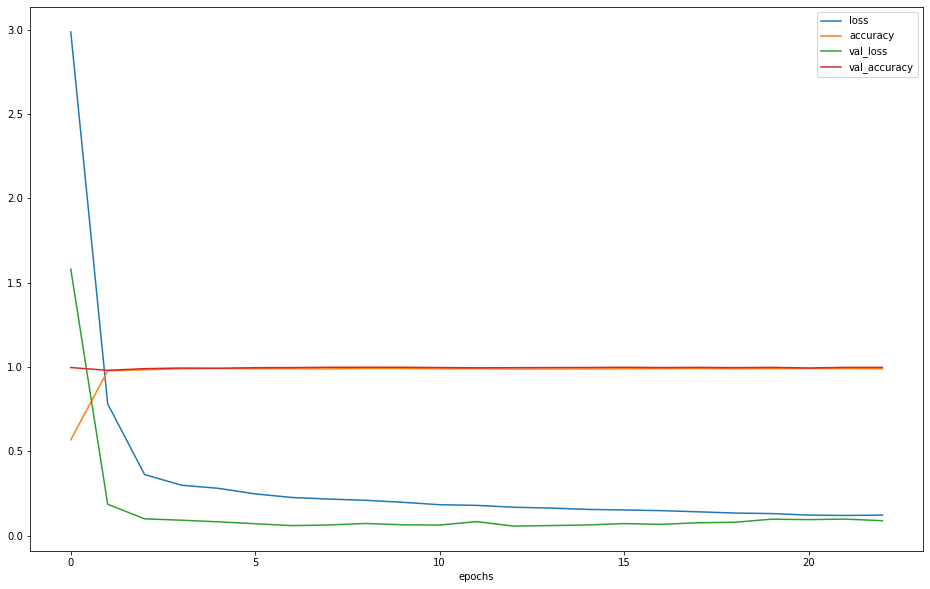

min val loss: 0.05647891387343407


In [251]:
#ticks = np.arange(0.0,1.01,0.05)

fig = plt.figure(figsize=(16,10))
df = pd.DataFrame(history.history)

#plt.yticks(ticks)
#plt.ylim(0.1,1.05)
plt.xlabel('epochs')
plt.plot(df)
plt.legend(df.columns)
plt.show()

print('min val loss:',min(history.history['val_loss']))

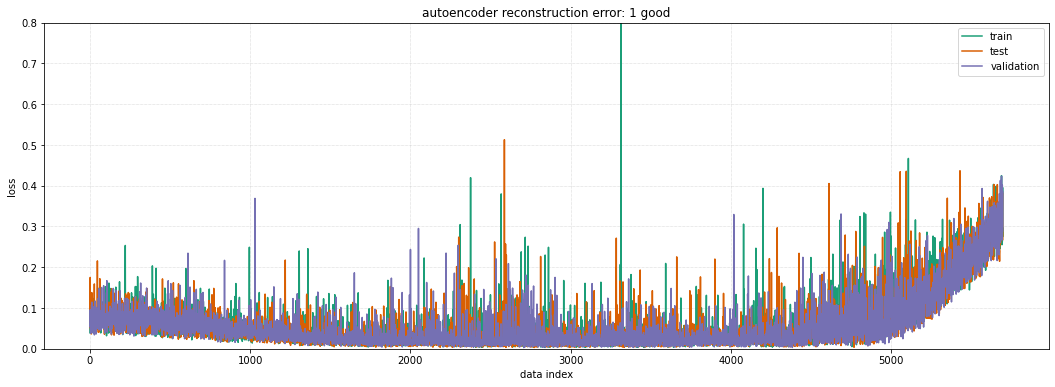

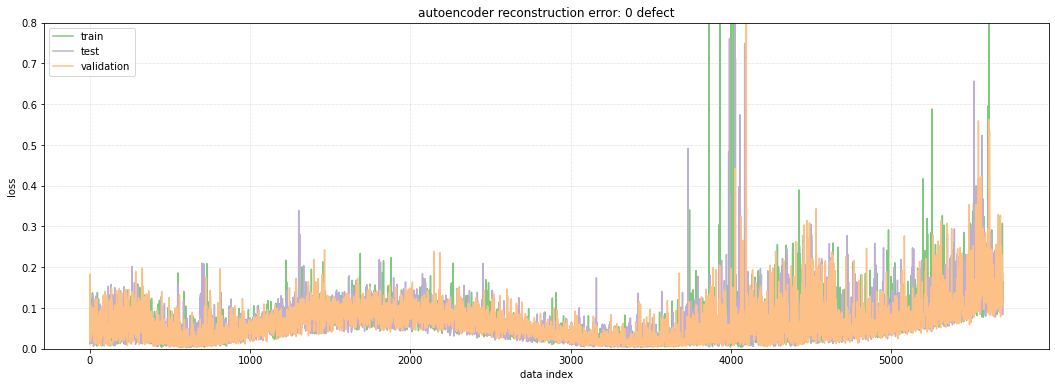

In [252]:
lab = ['train','test','validation']
title = ['1 good', '0 defect']
sets = [[G_trainp, G_testp, G_validp], [D_trainp, D_testp, D_validp]]
cmaps = [cm.Dark2, cm.Accent]

for t, set_, colorm in zip(title, sets, cmaps):
    
    fig = plt.figure(figsize=(18,6))
    plt.ylabel('loss')
    plt.xlabel('data index')
    plt.grid(linestyle=':', linewidth=0.5)
    plt.ylim(0,0.8)
    plt.title(f'autoencoder reconstruction error: {t}')
    
    for ind, l, s in zip(count(), lab, set_):
        
        predictions = autoencoder.predict(s)
        loss = np.mean(np.power(s - predictions, 2), axis=1)

        color = colorm(ind)

        error_df = pd.DataFrame({'reconstruction_error': loss})
        error_df.sort_index(inplace=True)
        error_df.reset_index(inplace=True)

        plt.plot(error_df['reconstruction_error'], label=f'{l}', color=color)
    
    plt.legend()
    plt.show()

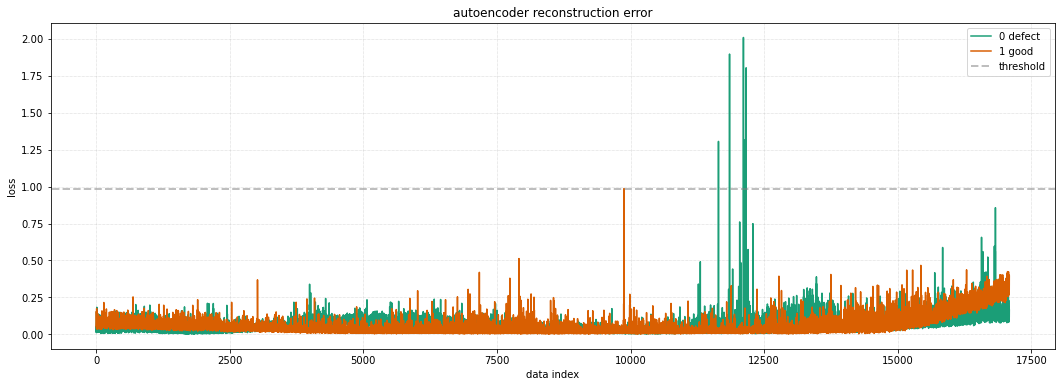

In [253]:
lab = ['0 defect','1 good']

fig = plt.figure(figsize=(18,6))
plt.ylabel('loss')
plt.xlabel('data index')
plt.grid(linestyle=':', linewidth=0.5)

plt.title('autoencoder reconstruction error')

for ind, d in enumerate([Dp, Gp]):
    
    predictions = autoencoder.predict(d)
    loss = np.mean(np.power(d - predictions, 2), axis=1)

    color = cm.Dark2(ind)
    
    error_df = pd.DataFrame({'reconstruction_error': loss})
    error_df.sort_index(inplace=True)
    error_df.reset_index(inplace=True)
    
    plt.plot(error_df['reconstruction_error'], label=f'{lab[ind]}', color=color)
    
    

threshold = np.max(error_df[1:]['reconstruction_error'])


plt.axhline(threshold,-1,17100, color='tab:grey', linestyle='--', lw=2, alpha=0.5, label='threshold')
    
plt.legend()
plt.show()

## classify with autoencoder reconstruction error

In [ ]:
#autoencoder = load_model("autoencoder3.h5")

fig = plt.figure(figsize=(18,6))
plt.ylabel('loss')
plt.xlabel('data index')
#plt.ylim((0, 1000))
plt.title('autoencoder reconstruction error')

plt.grid(linestyle=':', linewidth=0.5)

for i in [0, 1]:
    predictions = autoencoder.predict(X_train[Y_train==i])
    
    color = cm.Dark2(i)
    
    #loss = loss_fn(X_train[Y_train==i], predictions).numpy()
    loss = np.mean(np.power(X_train[Y_train==i] - predictions, 2), axis=1)

    error_df = pd.DataFrame({'reconstruction_error': loss, 'true_class': Y_train[Y_train==i]})
    error_df.sort_index(inplace=True)
    error_df.reset_index(inplace=True)
    plt.plot(error_df['reconstruction_error'], label=f'{i} {title[i]}', color=color)
    

predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
threshold = np.max(error_df[1:]['reconstruction_error'])


plt.axhline(threshold,-5,235, color='r', linestyle='--', label='threshold')
plt.legend()
plt.show()

print(f'Mean mse of decoded vals: {np.mean(mse)}\nDecision threshold of decoded vals: {threshold}')


y_pred_ae = ae_classy(mse,threshold)
        
        
unique, counts = np.unique(y_pred_ae, return_counts=True)
    
print('Class prediction done: ',unique,counts)


In [ ]:
y_pred_ae = np.array(y_pred_ae)

ae_auc = clust_eval(y_pred_ae, Y_train, "autoencoder")
aucs.append(ae_auc)

In [ ]:
tit = ['GMM', 'kmeans', 'OCSVM', 'AE']
pos = range(len(tit))

fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(111)

ax.bar(pos, aucs, align='center')
plt.xticks(pos, tit)
ax.set_title('AUC')




for ind, i in enumerate(ax.patches):
    ax.annotate(f'{aucs[ind]:.4}', (ind,1), xytext=(0,1), textcoords="offset points",
                    ha='center', va='bottom')
    
plt.show()

# Visualisierung des Datensets mit t-SNE

In [ ]:

X_train_tsne = []
lr = 10

p = [3] #[1, 3, 5, 10, 30, 50, 90] 


for ind, i in enumerate(p):
    print(f'##############\n{ind+1}/{len(p)}: t-sne p={i} learning_rate={lr} for {np.shape(X_train)}\n##############')
    tsne = TSNE(n_components=2,  perplexity=i, learning_rate=lr, verbose=0, angle=0.2, n_jobs=-1)
    Y = tsne.fit_transform(X_train)

    X_train_tsne.append(Y)

In [ ]:
for i, Y in zip(p, X_train_tsne):
    print('############## plot',np.shape(Y),' for p =',i,'####################################################################')
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(221)
    ax.set_title(f'tsne reduced: perplexity={i} GMM class')
    scat = ax.scatter(Y[:,0], Y[:,1], marker='.', c=labels , cmap=cm. copper)
    plt.legend(*scat.legend_elements(), loc="lower left", title="Classes")
    
    ax1 = fig.add_subplot(222)
    ax1.set_title(f'tsne reduced: perplexity={i} ocsvm class')
    scat1 = ax1.scatter(Y[:,0], Y[:,1], marker='.', c=ocsvm_pred , cmap=cm.copper)
    plt.legend(*scat1.legend_elements(), loc="lower left", title="Classes")

    ax2 = fig.add_subplot(223)
    ax2.set_title(f'tsne reduced: perplexity={i} autoencoder class')
    scat2 = ax2.scatter(Y[:,0], Y[:,1], marker='.', c=y_pred_ae, cmap=cm.copper)
    plt.legend(*scat2.legend_elements(), loc="lower left", title="Classes")
    
    ax3 = fig.add_subplot(224)
    ax3.set_title(f'tsne reduced: perplexity={i} true class')
    scat3 = ax3.scatter(Y[:,0], Y[:,1], marker='.', c=Y_train, cmap=cm.copper)
    plt.legend(*scat3.legend_elements(), loc="lower left", title="Classes")
    
    plt.show()
    

# Lernkurve Autoencoder

In [ ]:
loss_0 = []
loss_1 = []
loss_train = []
loss_val = []

time_start2 = time.time()
time_start = time.time()
over = [1 ,2 , 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97,
        102, 107, 112, 122, 142, 152, 162, 172, 182, 192, 202, 212, 222]

interval = len(over)/4

print(f'learning curve for {len(over)} iterations... ')

for ind, d in enumerate(over):
    
    file = Path(f'lc//autoencoder_{time.time()}_{ind}.h5').absolute().as_posix()

    x_train_lc = x_train[y_train==1][:d]
    x_valid_lc = x_valid[y_valid==1][:d]
    X_train[Y_train==i]
    
    lcmodel, checkpointer, early_stopping = create_model(loss_fn, input_dim, file)

    
    lchistory = lcmodel.fit(x_train_lc, x_train_lc,
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,  
                            validation_data=(x_valid_lc, x_valid_lc),
                            verbose=0,
                            callbacks=[checkpointer, early_stopping])
    
    loss = []
    
    for i in [0,1]:
        predictions = lcmodel.predict(X_train[Y_train==i])
        loss.append(np.mean(np.power(X_train[Y_train==i] - predictions, 2), axis=1))
    
    loss_train.append(np.mean(lchistory.history['loss']))
    loss_val.append(np.mean(lchistory.history['val_loss']))
    loss_0.append(np.mean(loss[0]))
    loss_1.append(np.mean(loss[1]))
    
    if (interval==ind+1):
        print(f'Done {ind+1} iterations so far.. took {time.time()-time_start:.8}s..')
        time_start = time.time()
        interval=interval+len(over)/4
        
print(f'Done... took {time.time()-time_start2:.8}s')

In [ ]:
fig = plt.figure(figsize=(16,10))

plt.ylim(0.05,0.37)
plt.xlim(-2,225)
plt.title('autoencoder lernkurve')
plt.xlabel('trainingset size')
plt.ylabel('loss')
plt.plot(over, loss_0, label='whole 0')
plt.plot(over, loss_1, label='whole 1')
plt.plot(over, loss_train, label='train')
plt.plot(over, loss_val, label='val')
plt.legend()
plt.show()


# Fazit